In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST contiene 60,000 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
# Se carga el dataset desde keras
fashion_mnist = keras.datasets.fashion_mnist

# Extraen las "X" (images) y las "Y" (labels)
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

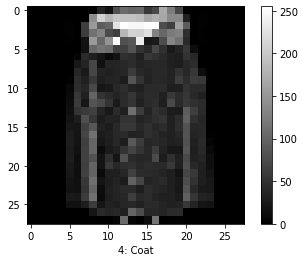

In [3]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

img_number = 96
plt.imshow(train_images[img_number], cmap = 'gray')
plt.xlabel(f"{train_labels[img_number]}: {classes[train_labels[img_number]]}")
plt.colorbar()
plt.show()

## Labels

Las labels consisten de variables categóricas que describen el tipo de prenda encontrada en la imagen de 28x28

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

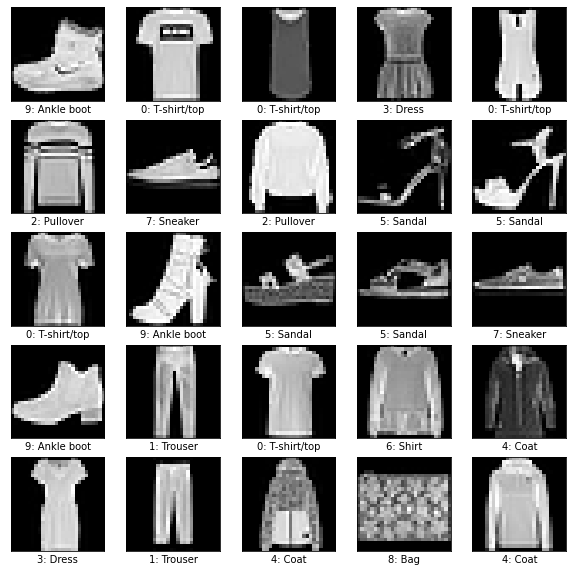

In [4]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(f"{train_labels[i]}: {classes[train_labels[i]]}")
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [5]:
# Diccionario con las clases de prenda
classes = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag", 
    9 : "Ankle boot"
}

# 3 clases a extraer. Colocarlas en el mismo orden que en el diccionario
selected_classes = ["Shirt", "Sneaker", "Bag"]

# Se obtienen las "keys" de las clases a extraer
# Para esto se itera sobre cada pareja de "key/value" en "classes"
# Y para cada pareja se chequea si el valor está contenido en "selected_classes"
selected_classes_code = [key for key,val in classes.items() if val in selected_classes]

Extraer las clases seleccionadas del dataset

In [6]:
# Función para extraer las 3 clases seleccionadas previamente de los datasets de prueba y entrenamiento
def extractClassSubset(x_data, y_data, sel_classes):

    condicion = (y_data == sel_classes[0]) | (y_data == sel_classes[1]) | (y_data == sel_classes[2])

    # Se extraen los datos que corresponden a las 3 clases seleccionadas
    y_data_ex = y_data[condicion]
    x_data_ex = x_data[condicion]

    # Se reclasifican las labels de cada clase como "0, 1 y 2"
    y_data_ex[y_data_ex == sel_classes[0]] = 0
    y_data_ex[y_data_ex == sel_classes[1]] = 1
    y_data_ex[y_data_ex == sel_classes[2]] = 2

    return x_data_ex, y_data_ex

# Extracción de las clases seleccionadas
train_images_ex, train_labels_ex  = extractClassSubset(train_images, train_labels, selected_classes_code)
test_images_ex, test_labels_ex  = extractClassSubset(test_images, test_labels, selected_classes_code)

# Las clases se "remapean" a un rango entre 0 y 2. Se crea un nuevo diccionario
classes_ex = {
    0 : selected_classes[0],
    1 : selected_classes[1],
    2 : selected_classes[2]
}

Aplicar regresión logística con entropía cruzada como función de costo

In [38]:
# Definición de función encargada de crear un grafo para hacer una regresión logística
def Create_LogRegGraph(NumFilas, NumCols, NumCat):

    # Se reinicia la creación del grafo creado
    tf.reset_default_graph()

    # Se crea un objeto de tipo grafo
    grafo = tf.Graph()

    # Se incluyen nodos dentro del grafo
    with grafo.as_default():

        # Input: Se definen los datos de entrenamiento
        # X: Tantas filas como imágenes (None para un tamaño variable). Tantas columnas como pixeles (+ 1 columna de unos)
        # Y: Tantas filas como imágenes (None para un tamaño variable). 1 columna
        X = tf.placeholder(tf.float32, [None, NumCols], "X")
        Y = tf.placeholder(tf.int32, [None, 1], "Y")

        # Input: Learning rate 
        learning_rate = tf.placeholder(dtype="float", name="lr")

        # Se inicializan los parámetros correspondientes a las pendientes y el bias (theta)
        # Dims: (NoPixeles, NoCategorias)
        params = tf.Variable(tf.zeros((NumCols, NumCat)), name="Theta", dtype=tf.float32)

        # Predicción de la salida dados los parámetros 
        # Dims Output: (NoMuestras, NoPixeles) x (NoPixeles, NoCategorias) = (NoMuestras, NoCategorias)
        with tf.name_scope("Predict"):
            
            # Se utiliza softmax para procesar los logits porque es necesario
            # que retorne una probabilidad para cada clase
            logits = tf.matmul(X, params)
            Y_hat = tf.nn.softmax(logits)

        # Cálculo del error por medio de entropía cruzada
        with tf.name_scope("Cross_Entropy"):
            
            # Se aplica one-hot encoding a las Y's o labels categóricas
            ohe_Y = tf.one_hot(Y, depth=NumCat)

            # Cálculo de la entropía cruzada
            error = - (1 / NumFilas) * tf.reduce_sum( ohe_Y *  tf.math.log(Y_hat) + (1 - ohe_Y) * tf.math.log(Y_hat))

            # Incluir el error en la parte de "Scalars" de Tensorboard
            error_summary = tf.summary.scalar("Error", error)

        with tf.name_scope("Accuracy"):

            # Se obtiene la label real (real_class) y la predicción con mayor probabilidad (pred_class)
            real_class = tf.math.argmax(ohe_Y, axis=2)
            pred_class = tf.reshape(tf.math.argmax(Y_hat, axis=1), [-1, 1])

            # Se chequea cuales predicciones son iguales a las labels reales (element-wise)
            correct_pred = tf.math.equal(real_class, pred_class)

            # Se suma el número de predicciones correctas y luego se divide dentro del número total de predicciones
            accuracy = tf.count_nonzero(correct_pred) / tf.cast(tf.shape(correct_pred)[0], dtype=tf.int64)

            # Se incluye el accuracy en la parte de "Scalars" de Tensorboard
            accuracy_summary = tf.summary.scalar("Accuracy", accuracy)

        # Obtener el valor de los gradientes para M y B
        grads_params = tf.gradients(error, params)

        # La operación de gradiente es acoplada a un print para facilitar el debugging
        #grads_print = tf.tuple(grads_params, control_inputs=[tf.print(accuracy)])

        # El gradiente retorna un tensor de más dimensiones de las que regresó. 
        # Ejemplo: Para un tensor de "params" 2D, tf.gradients retorna un tensor 3D con 2 elementos.
        # Se "aplanan" los datos para regresar a la forma original de params
        grads = tf.reshape(grads_params, tf.shape(params))

        # Actualizar los parámetros del algoritmo
        with tf.name_scope("Update"):
            delta_params = tf.assign(params, params - learning_rate * grads)

        # Inicializar variables globales
        init = tf.global_variables_initializer()

    return grafo, init, [X, Y], [learning_rate, delta_params, error_summary, params, error, accuracy_summary]

![grafo](grafo.png)

Función de entrenamiento que utiliza el grafo de regresión logística

In [39]:
# Función de entrenamiento
def Train(x, y, clases, lr, epochs, batch_size, metadata):

    # Se extraen las dimensiones de los datos de entrada
    num_fil = x.shape[0]
    num_col = x.shape[1]

    # Se toma nota del número de clases
    num_cat = len(clases)

    # Se crea un grafo nuevo con el número de columnas de X
    grafo, init, linRegIO, Nodes = Create_LogRegGraph(num_fil, num_col, num_cat)

    # Datos de entrenamiento (X) y labels (Y)
    X, Y = linRegIO

    # Se extrae la definición de los diferentes nodos utilizados luegos por TF
    learning_rate = Nodes[0]
    delta_params = Nodes[1]
    error_summary = Nodes[2]
    params = Nodes[3]
    costo = Nodes[4]
    accuracy_summary = Nodes[5]

    with tf.Session(graph = grafo) as sess:
        
        # Inicializa todas las variables de ser necesario
        tf.initialize_all_variables().run()

        # Crea un directorio para tensorboard
        # Generalmente el directorio "padre" de tensorboard es "graphs" pero puede cambiarse
        writer = tf.summary.FileWriter((f'./graphs/{metadata},lr={str(lr)},epochs={str(epochs)}'), sess.graph)

        # Inicializar el grafo
        sess.run(init)

        # Se inicializa un contador de minibatches
        current_minibatch = 0

        # Iterar para cada Epoch
        for epoch in range(epochs):

            # Se obtiene el número total de muestras
            total_samples = num_fil

            # Se crea una lista con los índices que se usan como límites para cada mini batch
            # Se retorna una lista de listas, donde cada sublista contiene el límite superior e inferior
            minibatch_indices = [[minibatch_num, minibatch_num + batch_size] for minibatch_num in range(0, total_samples, batch_size)]

            # El número de muestras tiende a no ser divisible dentro del batch size, por lo que
            # tiende a quedar un último mini batch con un tamaño menor al del batch size. La lista generada
            # anteriormente no toma esto en cuenta, entonces aquí se "trunca" el último límite superior de la lista anterior
            minibatch_indices[-1][1] = total_samples

            # Iterar para cada mini batch
            for ind_inf, ind_sup in minibatch_indices:

                # Se definen los inputs del grafo
                inputs_grafo = {
                    X : x[ind_inf:ind_sup, :],
                    Y : np.reshape(y[ind_inf:ind_sup], (-1,1)),
                    learning_rate: lr
                }

                # Se corre el grafo con los datos elegidos
                sess.run(delta_params, feed_dict=inputs_grafo)

                # Se incrementa el contador de minibatches
                current_minibatch += 1

                # Se agregan todos los escalares al tensorboard
                e = sess.run(error_summary, feed_dict=inputs_grafo)
                a = sess.run(accuracy_summary, feed_dict=inputs_grafo)
                writer.add_summary(e, current_minibatch)
                writer.add_summary(a, current_minibatch)          
        
        # Se extraen los parámetros resultantes de la regresión y el error
        theta = params.eval()
        error = costo.eval(feed_dict=inputs_grafo)
            
        # Finalizar el "writer" hacia tensor board
        writer.close()

    return theta, error

Función que predice la clase de la prenda según una imagen

In [42]:
def Predict(test_data, params):

    # Se importan los paquetes necesarios
    from sklearn.preprocessing import PolynomialFeatures

    # Se extraen las dimensiones de los datos de entrada
    alto_img, ancho_img = test_data.shape[1:3]

    # Se redimensionan los datos de entrada "aplanando" las imágenes
    test_flatten = np.reshape(test_data, (-1, alto_img * ancho_img))

    # Se le agrega una fila de unos a "test_x" convirtiendo los datos en un polinomio de grado 1
    poly = PolynomialFeatures(1)
    test_flatten = poly.fit_transform(test_flatten)

    # Se calculan los logits haciendo la regresión
    logits = np.matmul(test_flatten, params)

    # Se le aplica softmax a los logits
    y_hat = np.exp(logits) / np.sum(np.exp(logits))

    # Se retorna el índice del valor más alto o la categoría con mayor probabilidad
    return np.argmax(y_hat, axis=1)

Se carga Tensorflow v1

In [9]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Modelo con datos sin pre-procesar

Entrenamiento de modelo

In [41]:
from sklearn.preprocessing import PolynomialFeatures

# Se extraen las dimensiones de los datos de entrada
alto_img, ancho_img = train_images_ex.shape[1:3]

# Se redimensionan los datos de entrada "aplanando" las imágenes
train_x = np.reshape(train_images_ex, (-1, alto_img * ancho_img))

# Se le agrega una fila de unos a "train_x" convirtiendo los datos en un polinomio de grado 1
poly = PolynomialFeatures(1)
train_x = poly.fit_transform(train_x)

# Datos de salida o "y's"
train_y = train_labels_ex

# Se entrena el modelo 
Theta, Error = Train(train_x, train_y, classes_ex, lr=0.00001, epochs=1000, batch_size=32, metadata="T3_P1")


Presentar una muestra de todas las predicciones

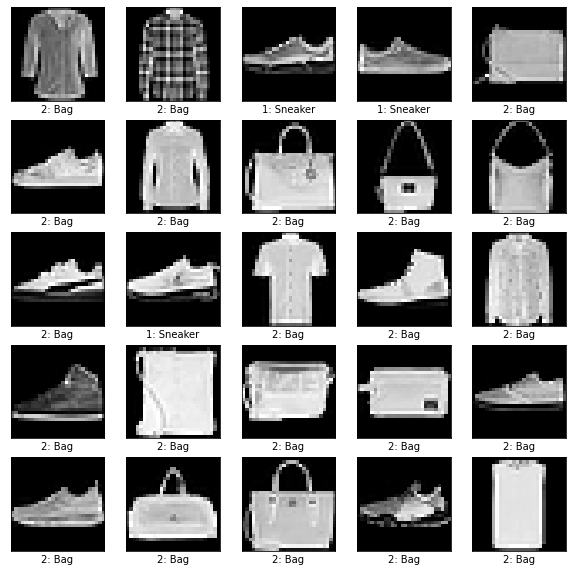

In [44]:
# Se realiza la predicción
clases_pred = Predict(test_images_ex, Theta)

# Se grafica la predicción en una cuadrícula
plt.figure(figsize=(10,10))
for i in range(25):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images_ex[i], cmap='gray')
    plt.xlabel(f"{clases_pred[i]}: {classes_ex[clases_pred[i]]}")

plt.show()

## Modelo con datos normalizados

Entrenamiento de modelo

In [56]:
# Se extraen las dimensiones de los datos de entrada
alto_img, ancho_img = train_images_ex.shape[1:3]

# Se redimensionan los datos de entrada "aplanando" las imágenes
train_x = np.reshape(train_images_ex, (-1, alto_img * ancho_img))

# Media y desviación estándar de los datos de entrenamiento
train_mu = np.reshape(np.mean(train_x, axis=1), (-1,1))
train_std = np.reshape(np.std(train_x, axis=1), (-1,1))

# Normalización de los datos
train_x_norm = (train_x - train_mu) / train_std 

# Se le agrega una fila de unos a "train_x" convirtiendo los datos en un polinomio de grado 1
poly = PolynomialFeatures(1)
train_x_norm = poly.fit_transform(train_x_norm)

# Datos de salida o "y's"
train_y = train_labels_ex

# Se entrena el modelo 
Theta_norm, Error_norm = Train(train_x_norm, train_y, classes_ex, lr=0.00001, epochs=1000, batch_size=32, metadata="T3_P1_norm")
